## Test the relation between knowledge distribition and the NLL of ripple effect
* defination of knowledge distribution: 
    * A->B edit A:->+C -> change B -> ripple effect
    * distribution between A and C: if a and c are not so related, the ripple cannot map the change in A to problem C so can not do ripple 
    * ways to measure distribition: $cos_{llama32layers}(gradient(A), gradient(C))$ on original model
    * ways to detect ripple effect: the NLL of B on edited model

In [1]:
from utils.all_imports import *
from utils.calculating_gradient import *
from utils.calculating_probability import *
torch.cuda.set_device(0)
from utils.all_imports import *
from utils.data_processing_utils import *


# import model and test_data
model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,0)
hparams = ROMEHyperParams.from_name("llama-7b")
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

test_data_path = "/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json"
with open(test_data_path,"r") as json_file:
    test_data = json.load(json_file)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
with open(f"inner_product_results{len(inner_product_results)}.json","w") as json_file:
    json.dump(inner_product_results,json_file)

In [ ]:
inner_product_results = []
for one_data in tqdm(test_data[16:]):
    edited_data = make_edited_data(one_data)
    edited_sentence_answer = edited_data['target']
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=True,return_diff_weights=True)
    
    # calculate the inner product between the gradient of the original sentence and the gradient of conditional sentence
    for query in one_data['compositional_I_problems']:
        one_data_results = dict() # initialize
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            inner_product = inner_product_between_contexts(model,tokenizer,query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer,model_device=6,plot=True)
            one_data_results['inner_product'] = inner_product
        print(query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer)
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            one_data_results['edited_sentence'] = edited_sentence
            one_data_results['edited_sentence_answer'] = edited_sentence_answer
            one_data_results['ripple_sentence'] = query['compositional_query']['prompt']
            one_data_results['ripple_sentence_answer'] = query['compositional_query']['answer']
            one_data_results['condition_query'] = query['condition_query']['prompt']
            one_data_results['condition_query_answer'] = query['condition_query']['answer']
            
            result = calculate_min_probability(model_edited,tokenizer,one_data_results['ripple_sentence'],[one_data_results['ripple_sentence_answer']],space_n=10)
        one_data_results['NLL'] = result
        inner_product_results.append(one_data_results)

In [ ]:
print(query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer)

In [ ]:
# debug
from torch import nn
a = "The official language of Italian Republic is"
b = "The name of the country of citizenship of John Prine is"
c = "Italian"
d = "Italian Republic"
inner_product = inner_product_between_contexts(model,tokenizer,a,b,c,d,model_device=0,plot=False)

In [ ]:
with open()

In [ ]:
for one_example in inner_product_results:
    mlp_down_project = [one_example['inner_product'][i] for i in one_example['inner_product'] if 'o_proj' in i]
    plt.figure(figsize=(12,3))
    plt.plot(mlp_down_project)
    plt.grid(True)
    plt.title(f"NLL:{min(one_example['NLL'])}")
    plt.show()

In [1]:
import json
with open(f"/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/cosine_results_q_rq50.json","r") as json_file:
    inner_product_results = json.load(json_file)

In [16]:
len(inner_product_results)

15

In [18]:
a = [one['inner_product']['model.layers.5.mlp.down_proj.weight'] for one in inner_product_results]
y = [min(one['NLL']) for one in inner_product_results]

In [29]:
names = [i for i in inner_product_results[0]['inner_product']]

/tmp/ipykernel_14520/2540263607.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(3,3))


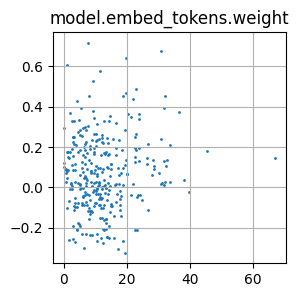

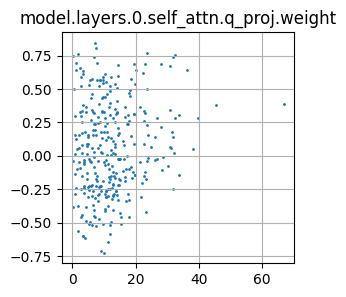

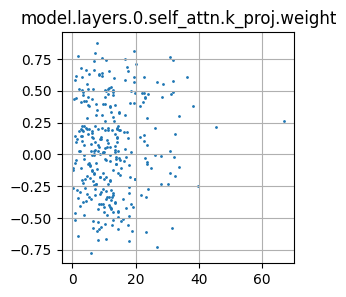

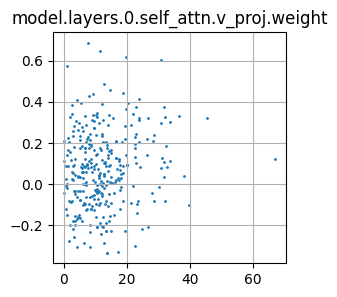

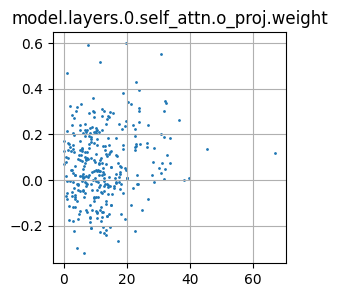

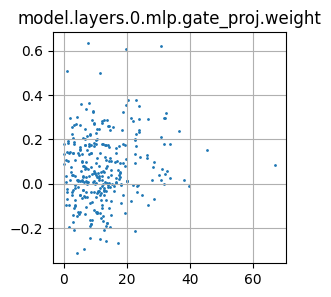

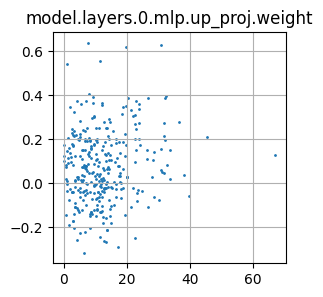

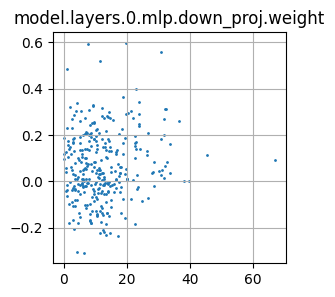

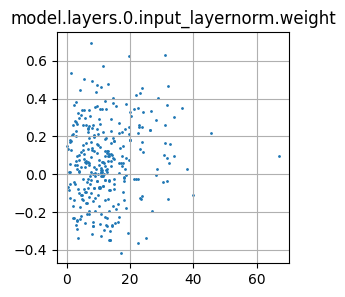

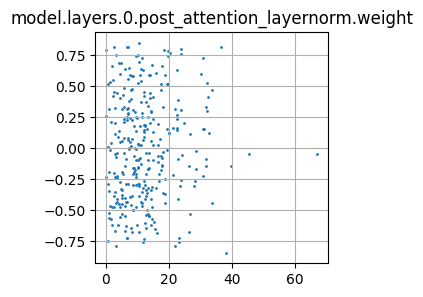

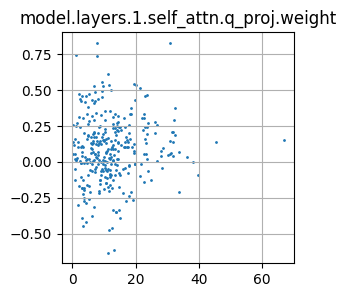

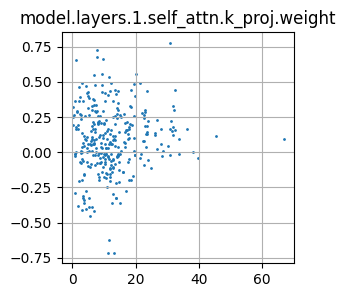

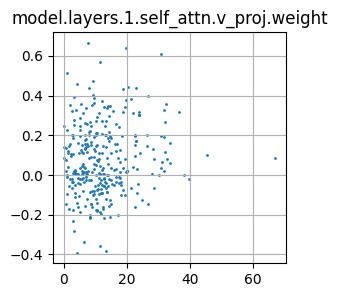

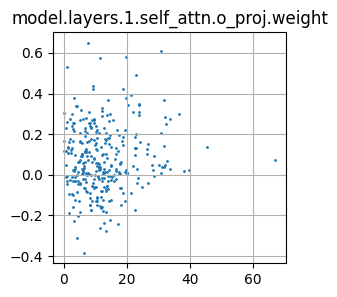

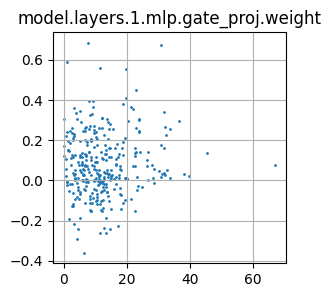

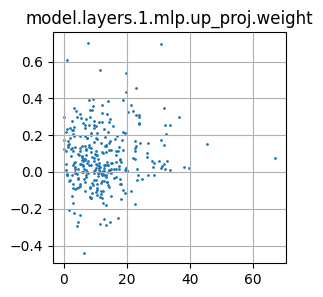

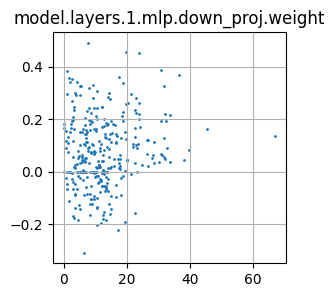

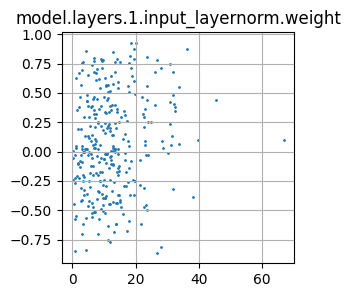

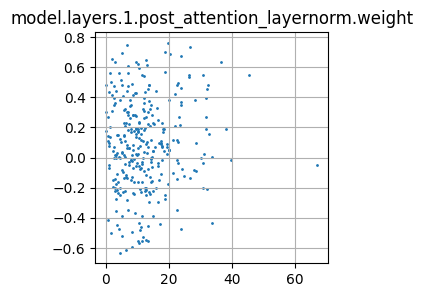

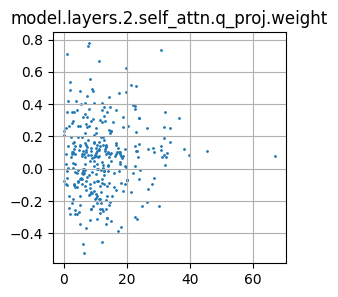

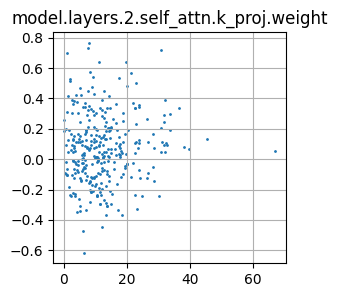

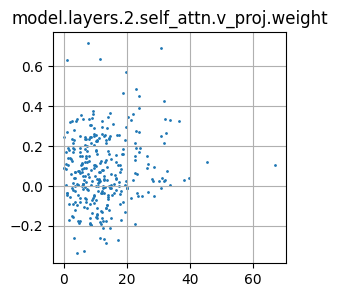

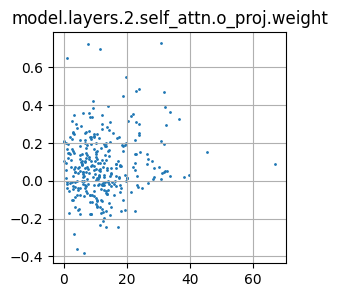

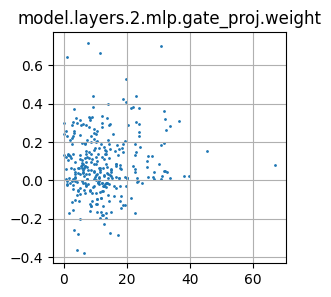

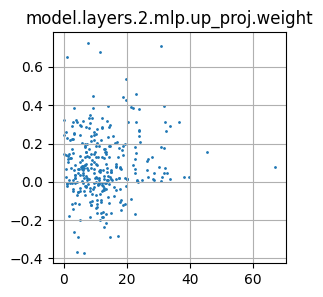

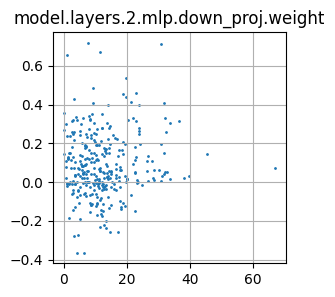

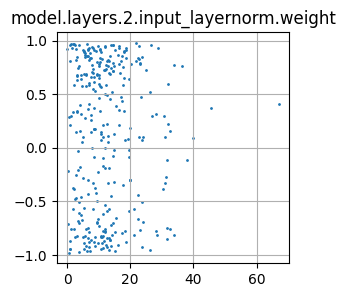

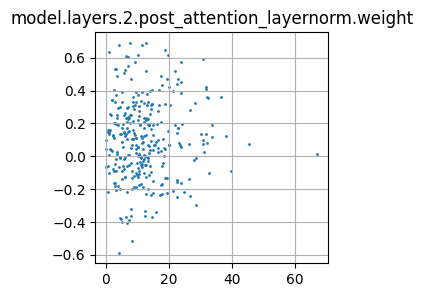

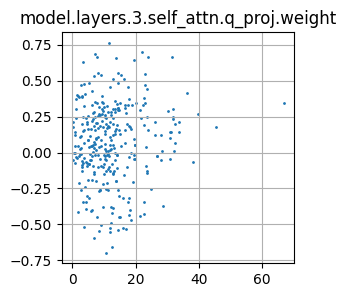

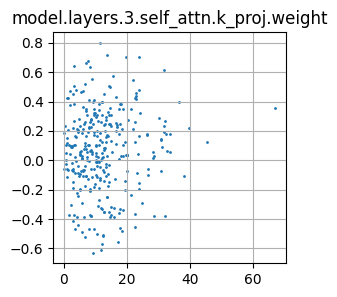

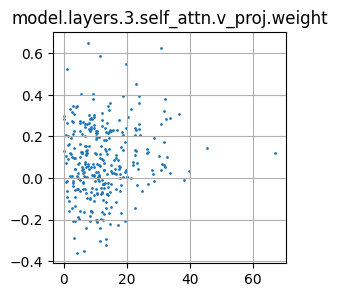

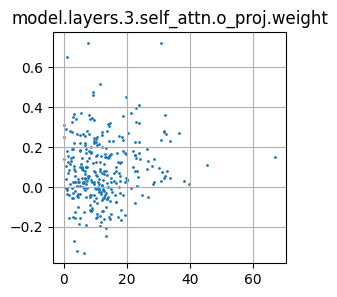

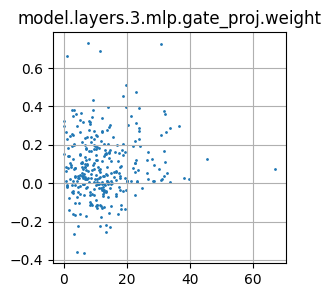

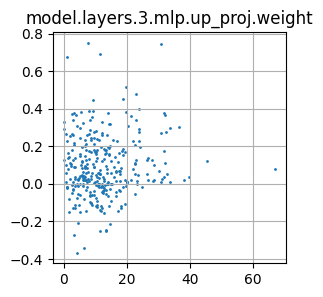

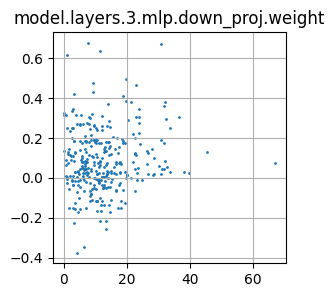

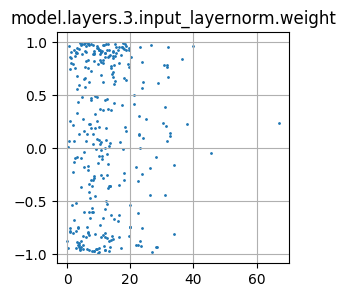

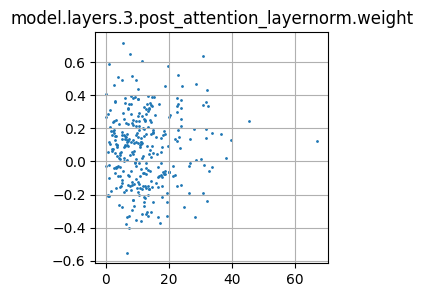

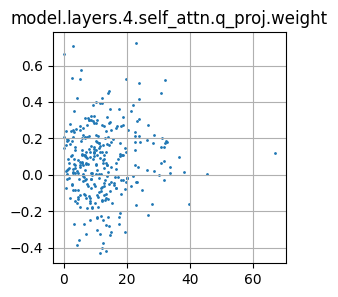

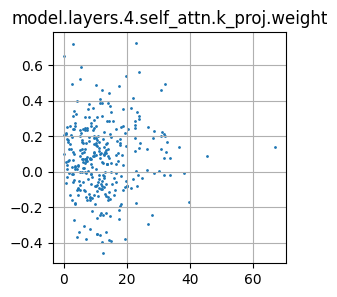

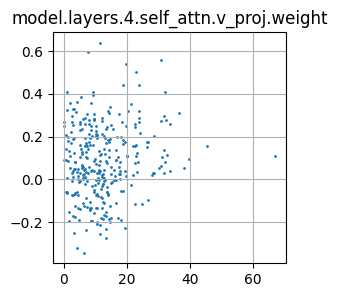

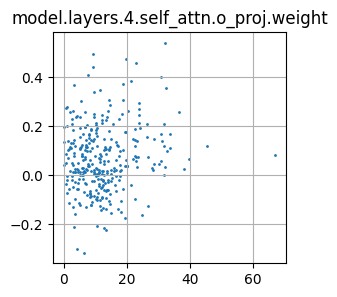

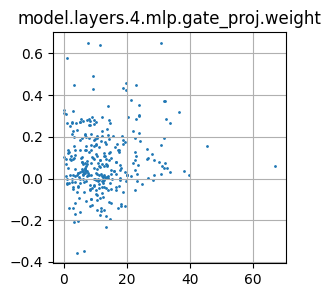

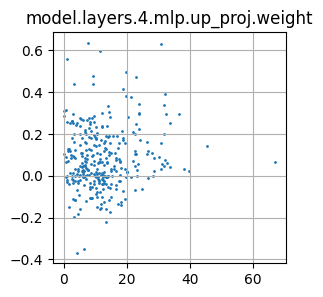

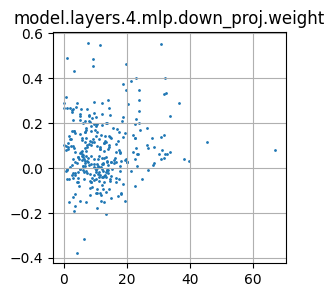

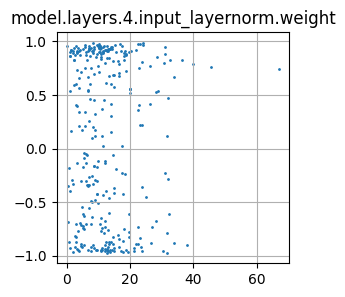

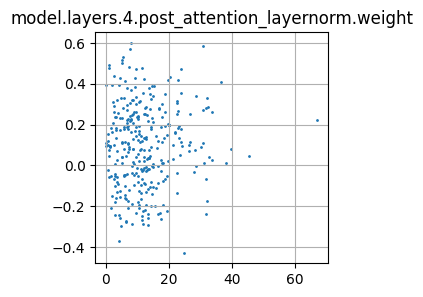

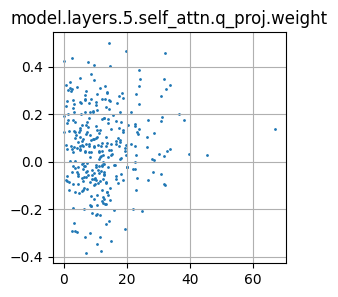

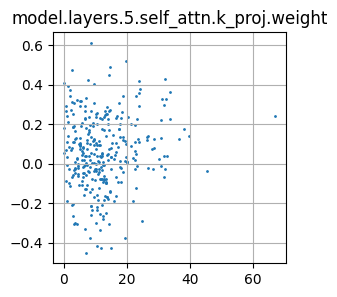

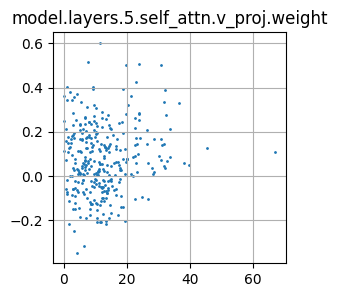

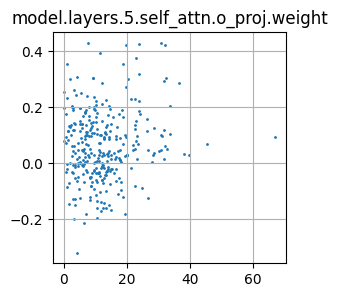

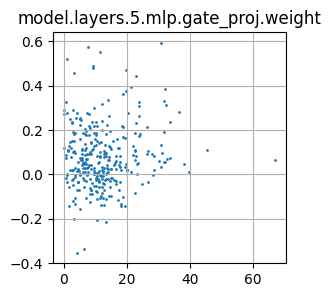

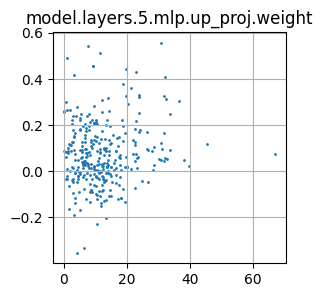

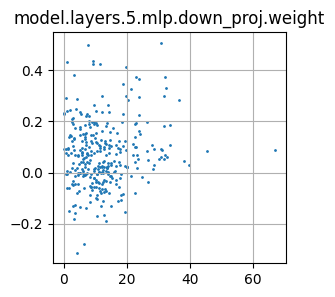

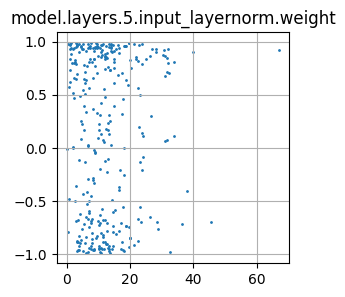

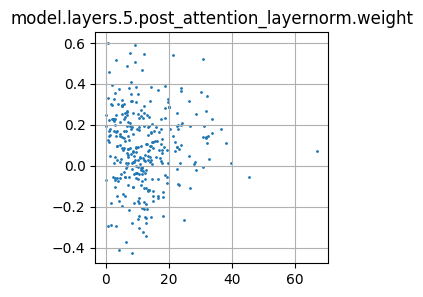

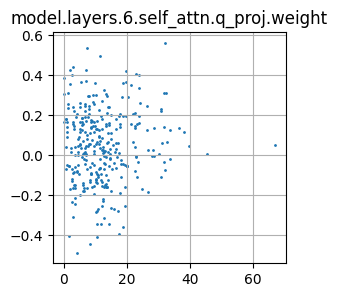

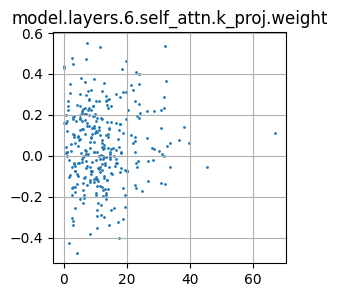

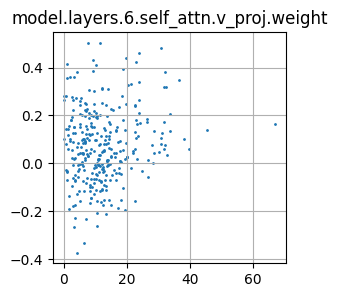

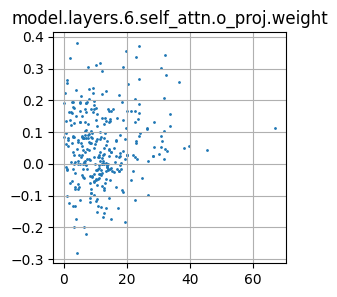

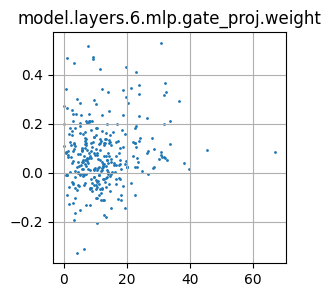

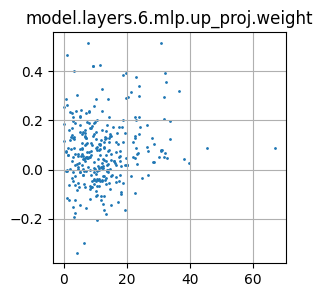

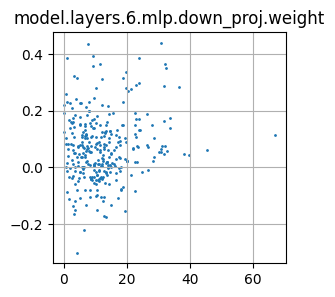

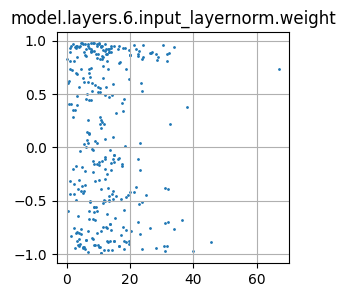

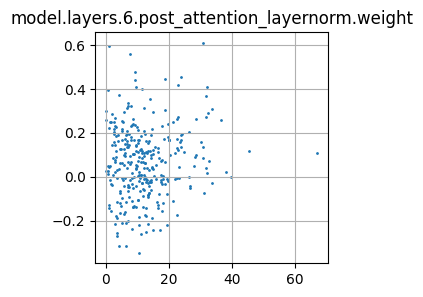

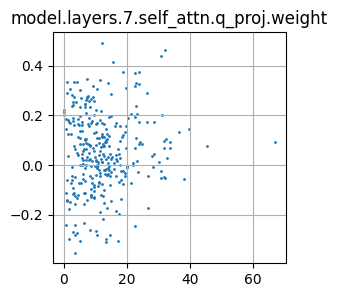

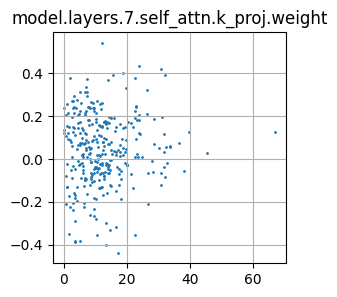

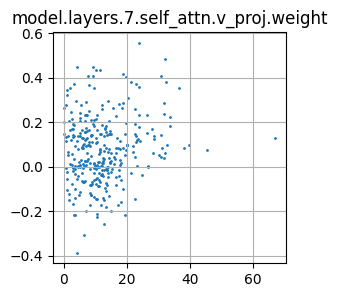

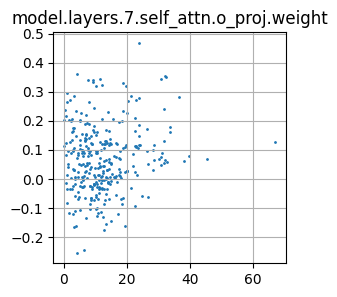

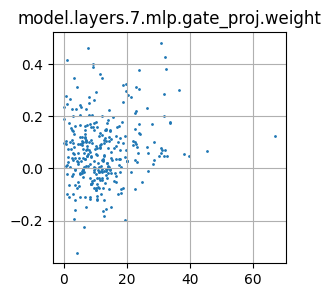

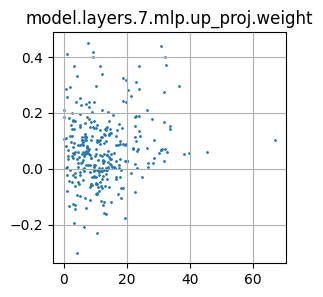

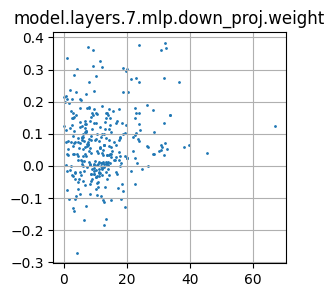

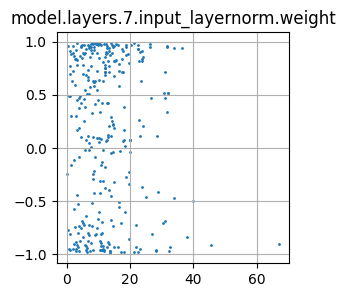

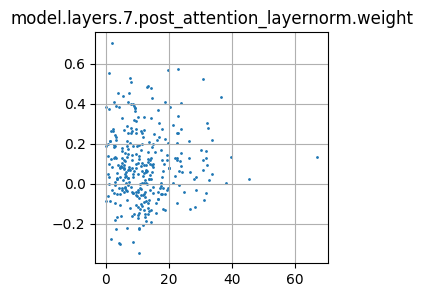

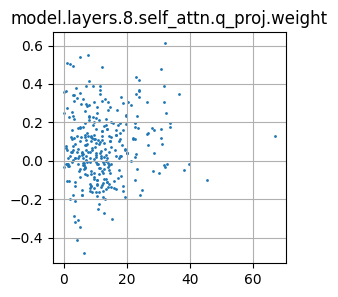

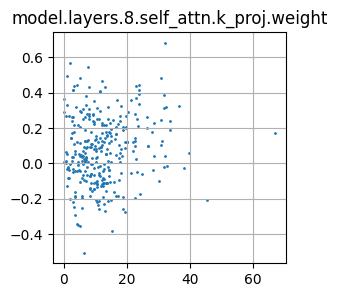

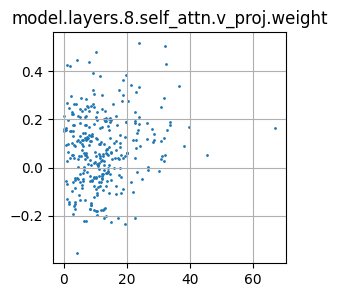

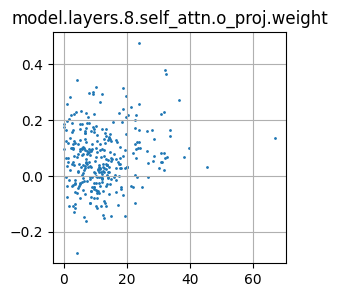

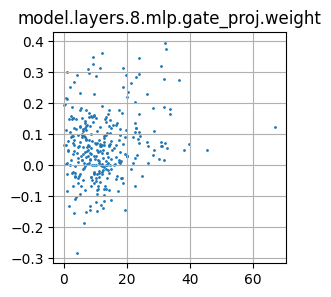

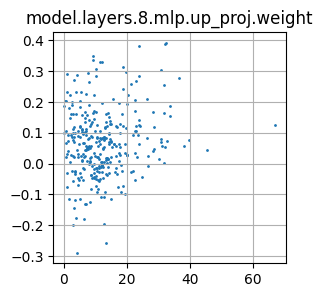

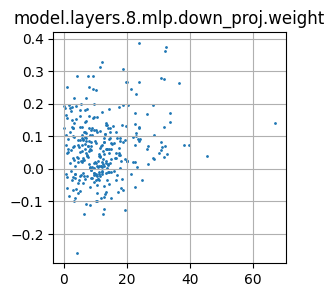

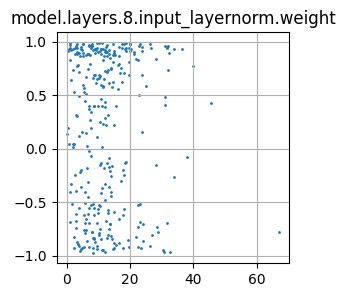

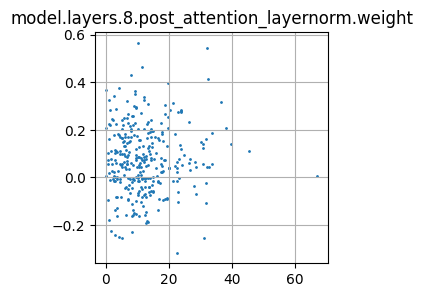

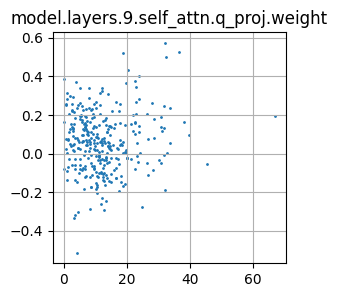

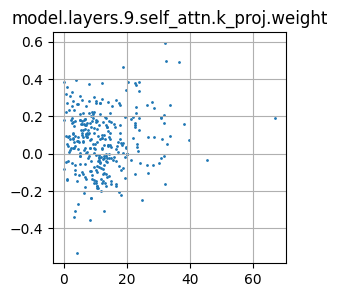

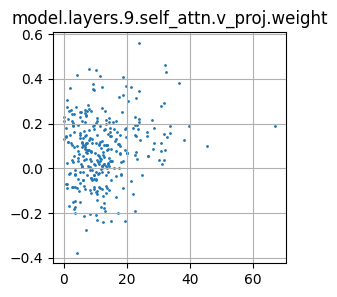

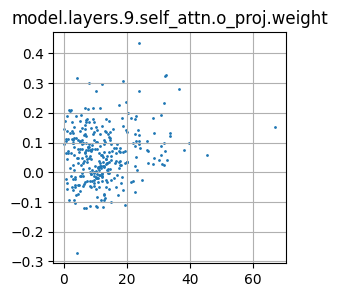

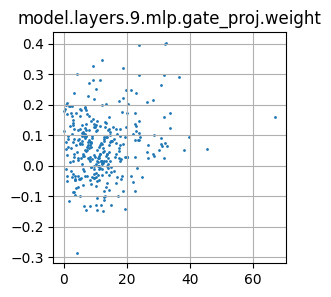

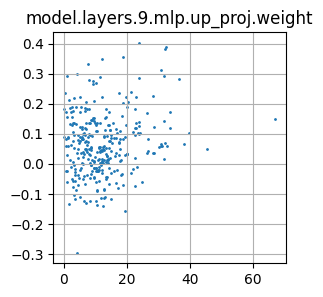

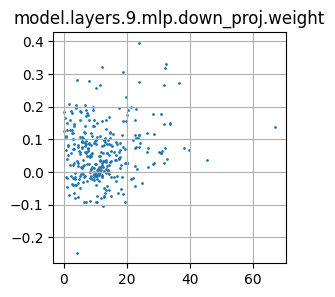

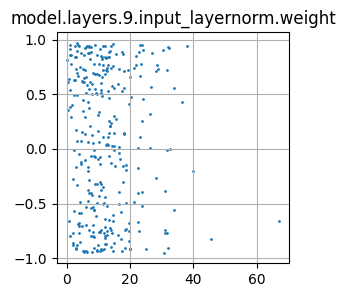

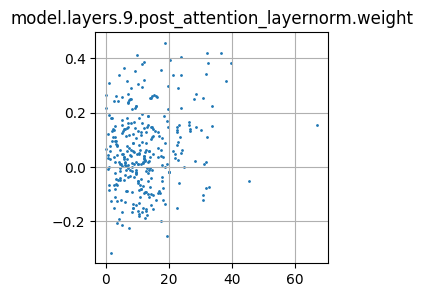

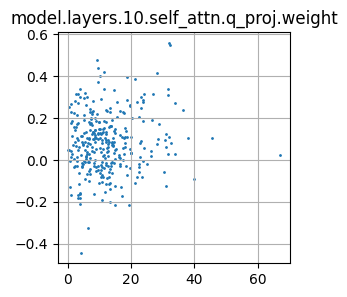

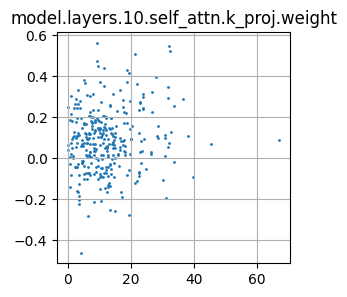

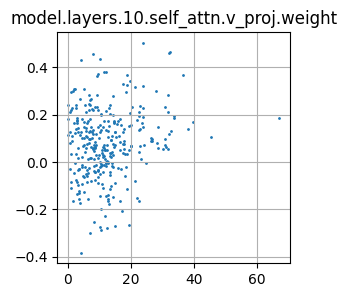

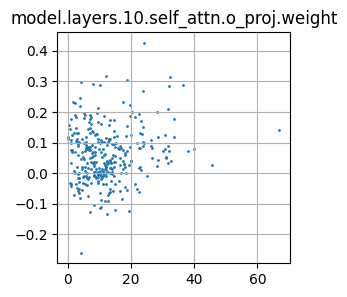

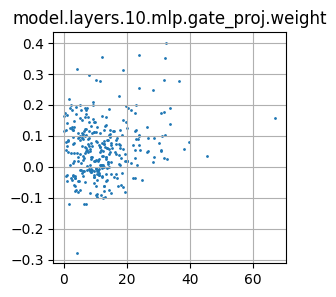

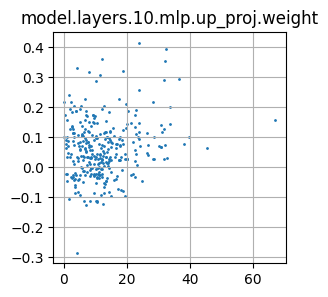

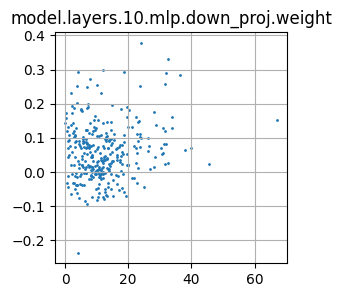

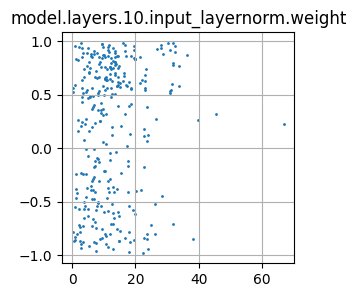

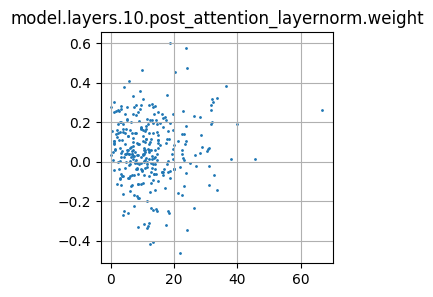

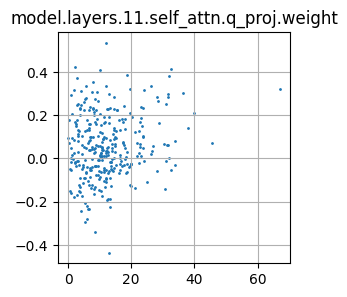

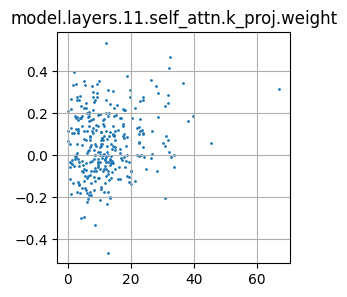

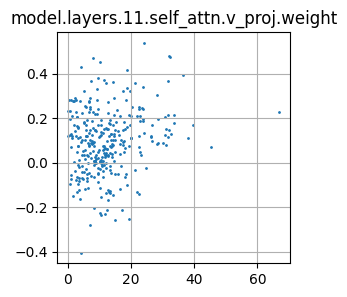

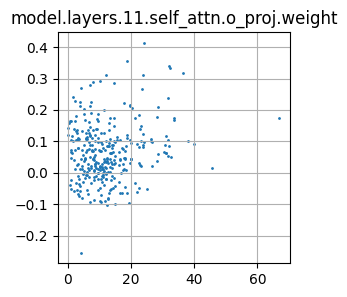

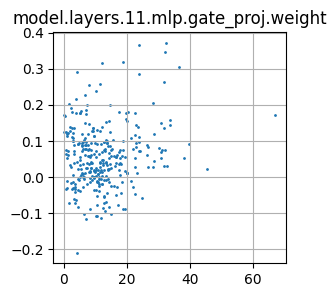

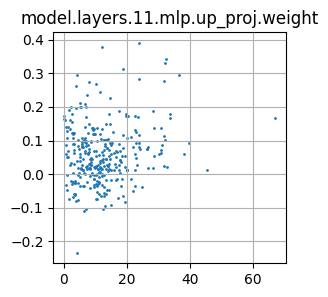

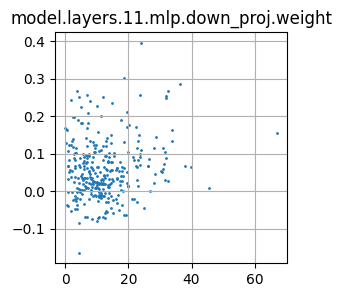

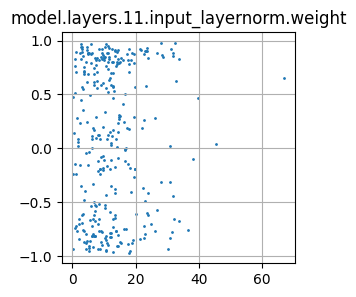

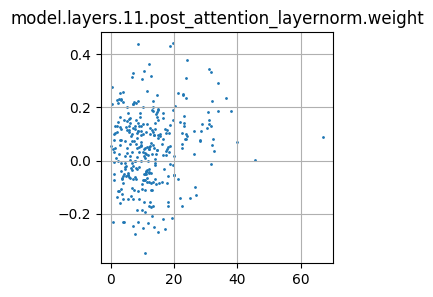

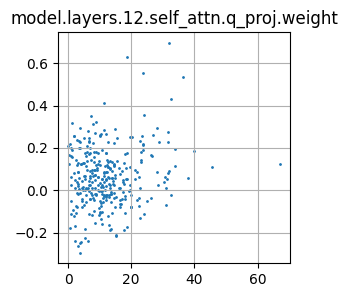

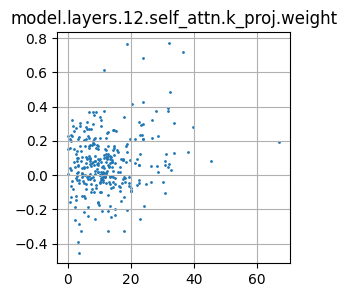

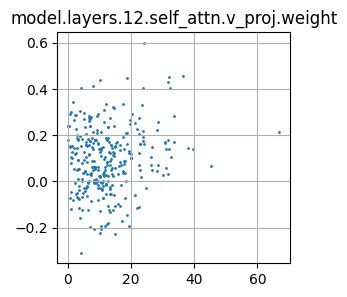

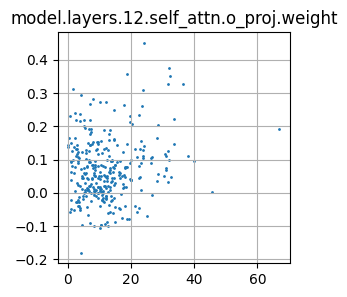

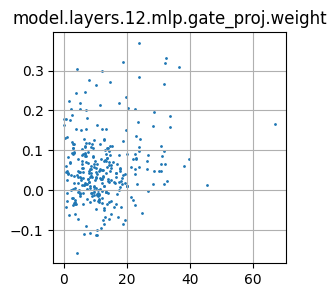

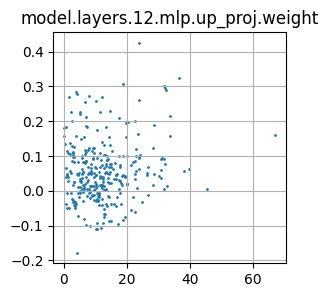

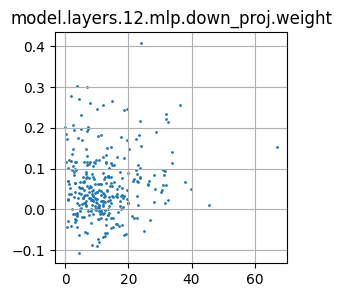

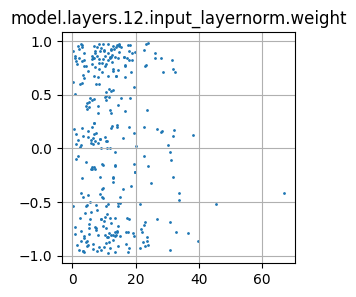

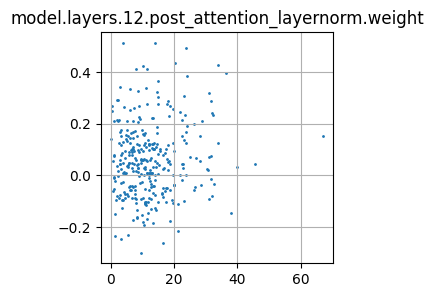

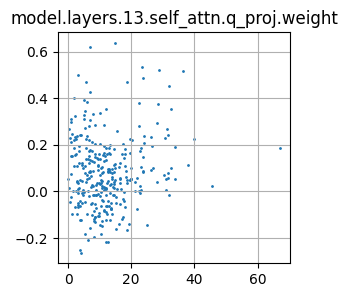

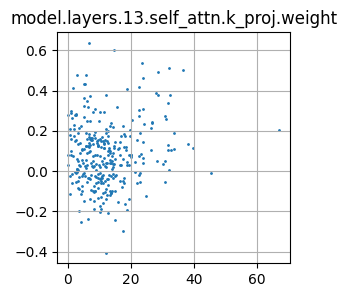

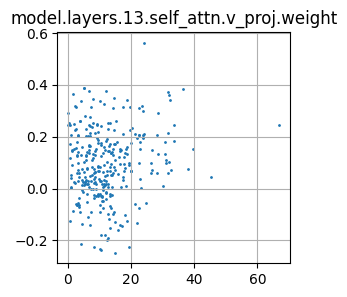

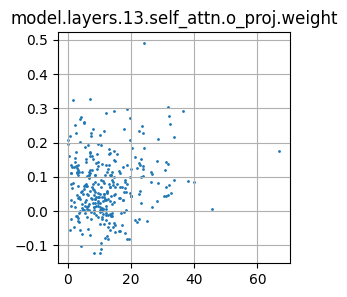

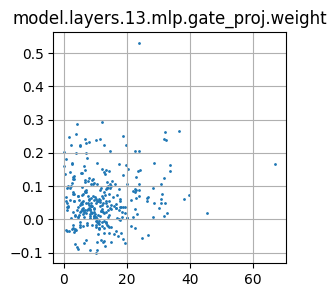

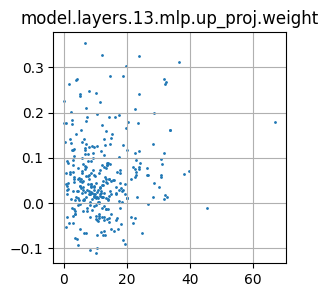

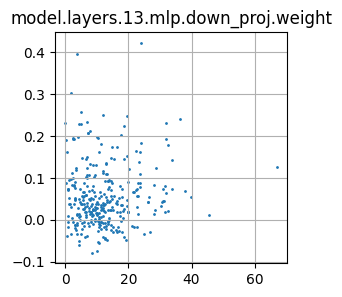

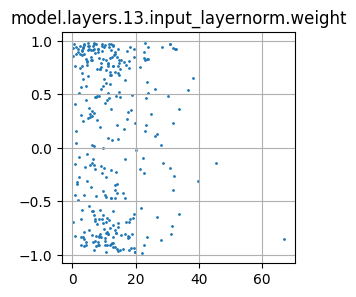

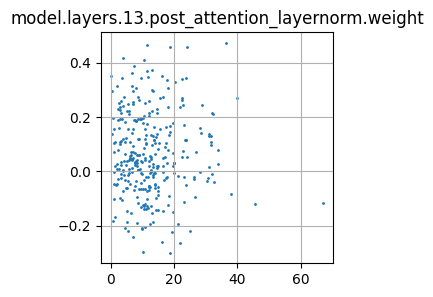

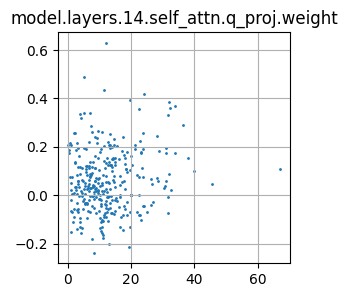

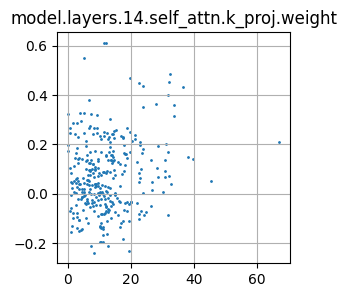

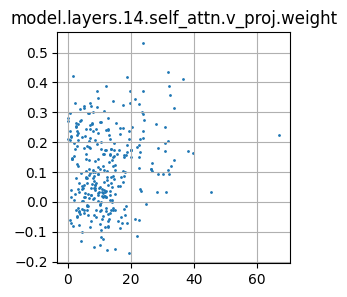

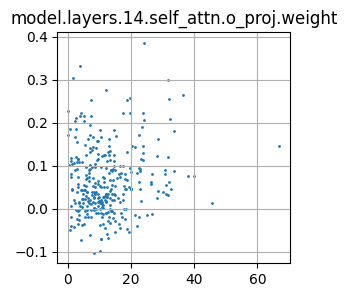

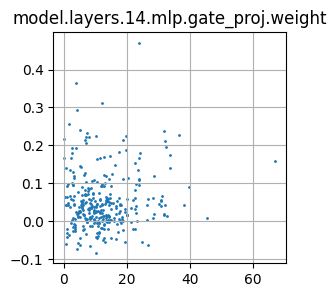

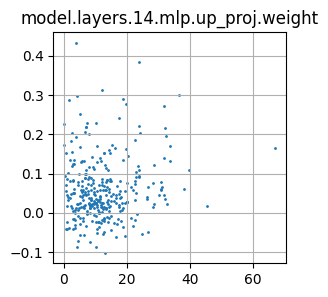

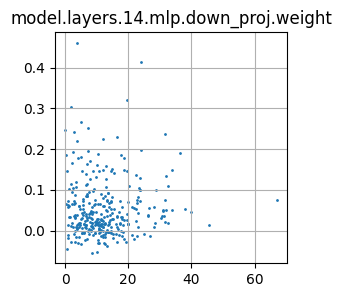

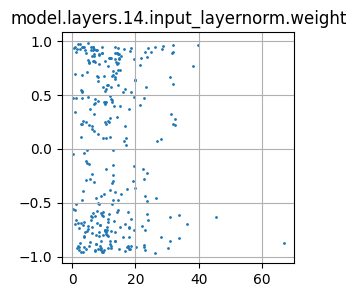

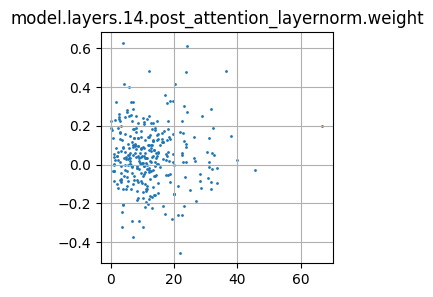

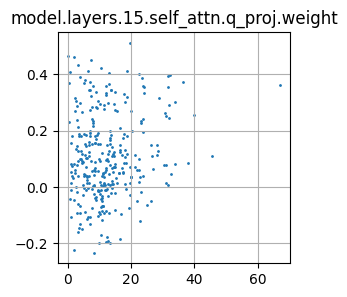

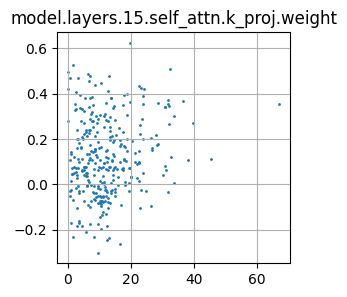

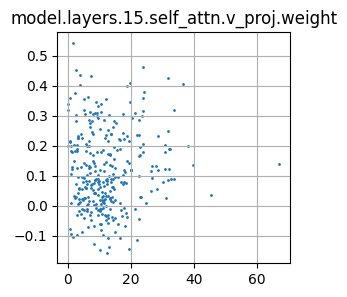

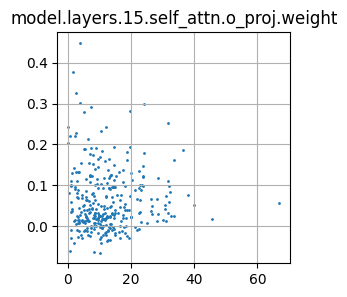

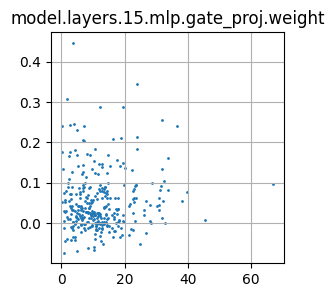

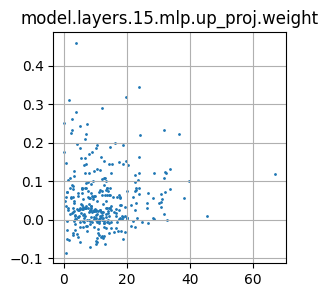

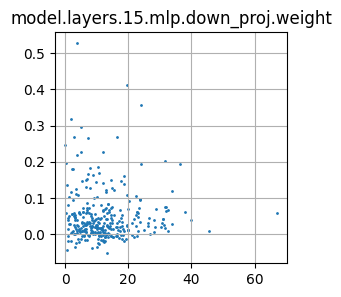

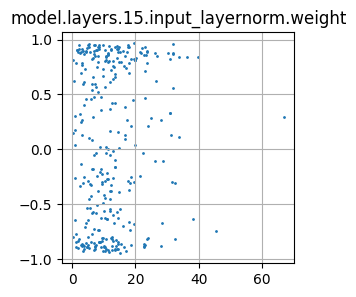

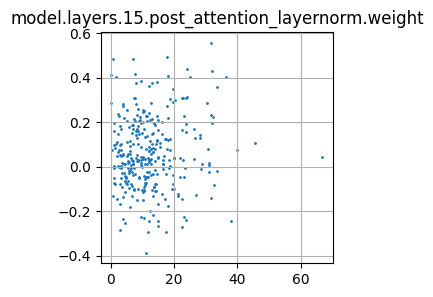

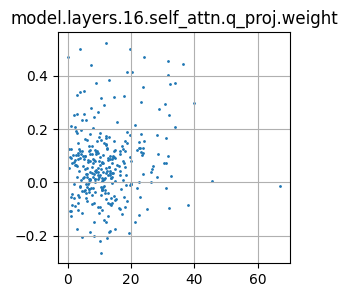

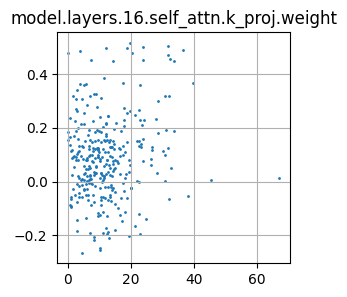

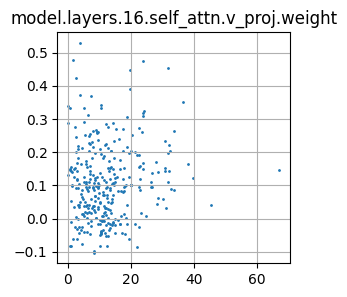

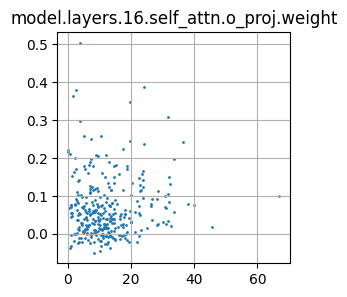

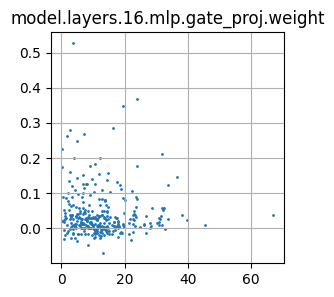

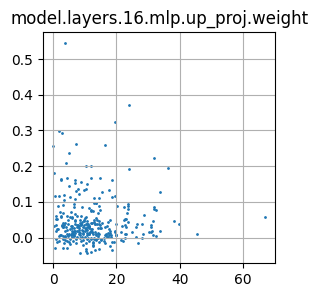

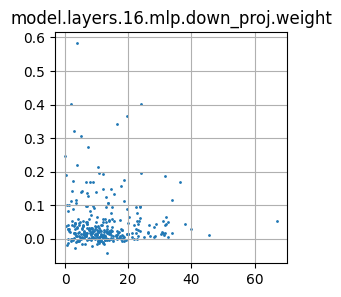

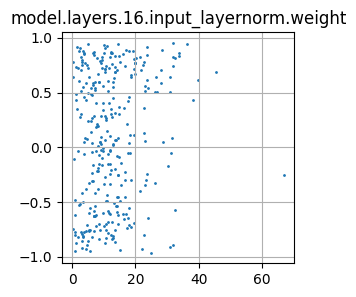

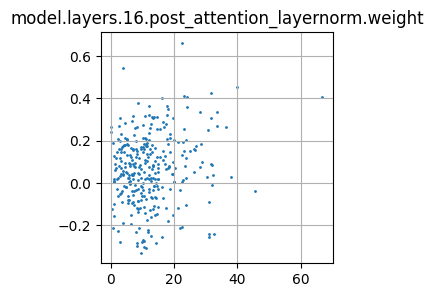

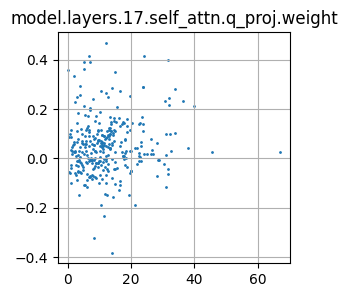

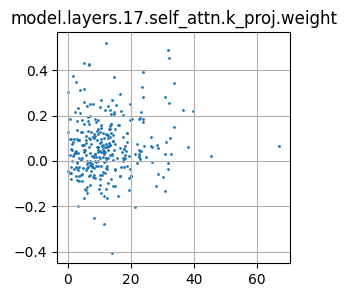

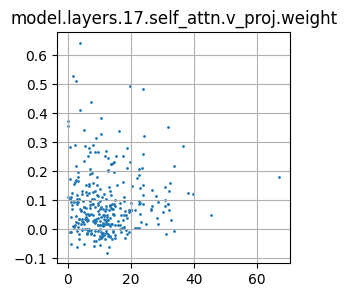

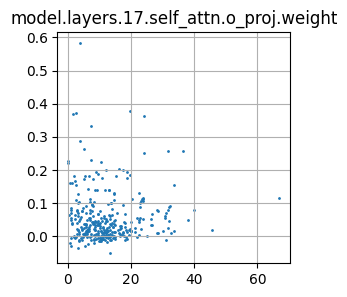

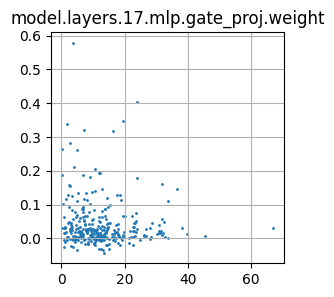

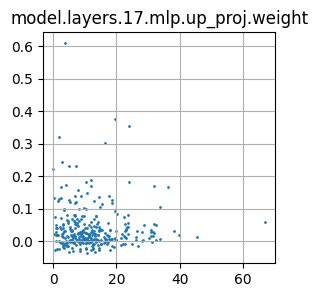

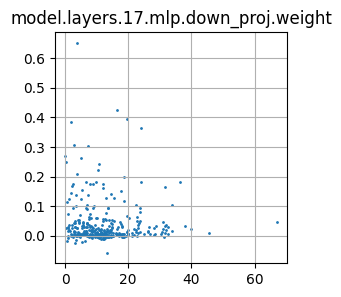

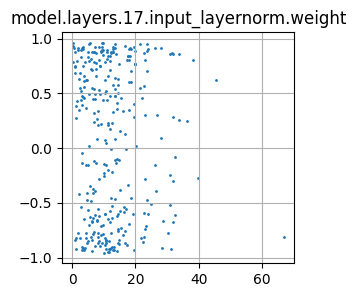

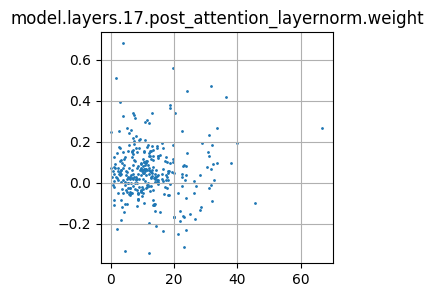

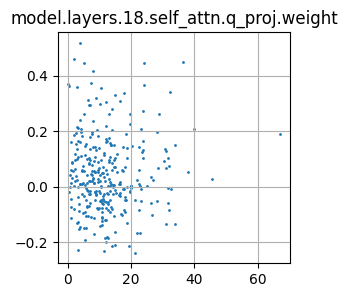

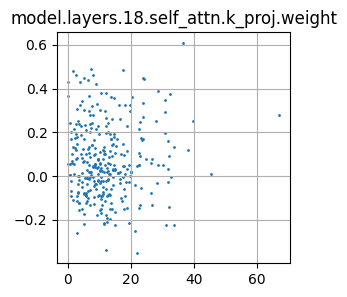

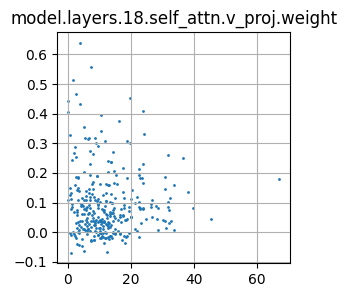

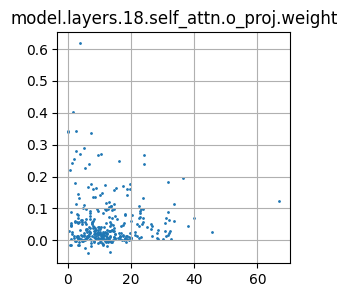

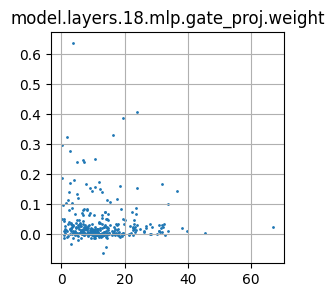

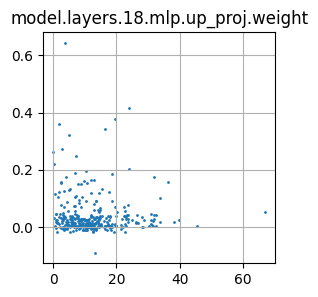

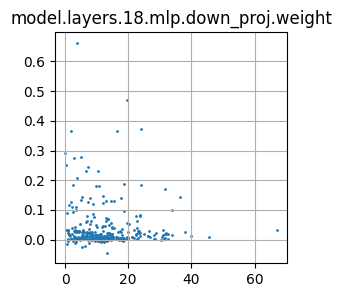

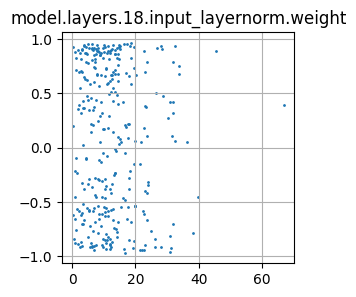

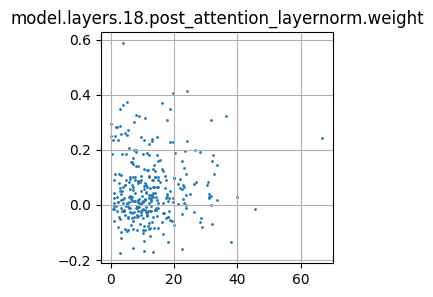

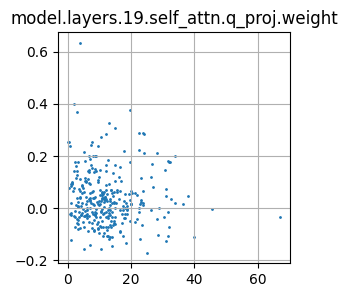

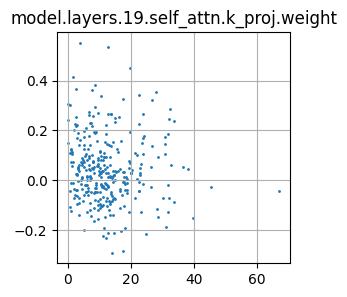

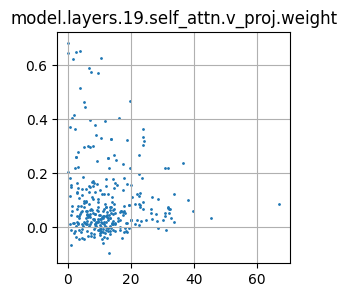

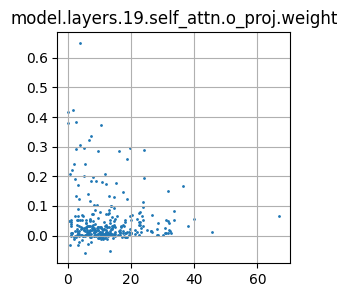

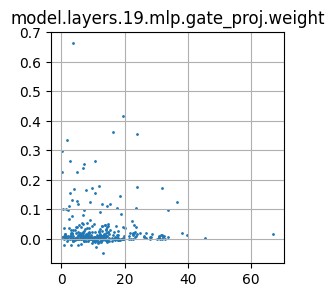

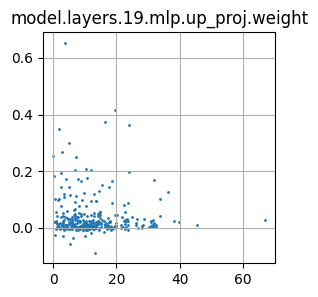

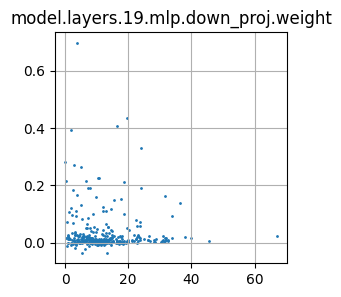

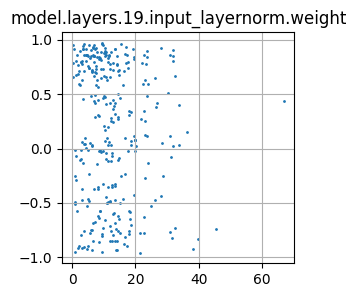

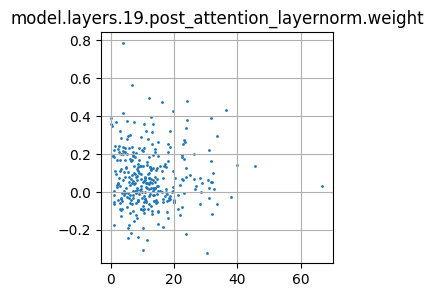

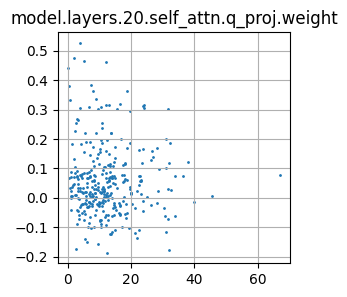

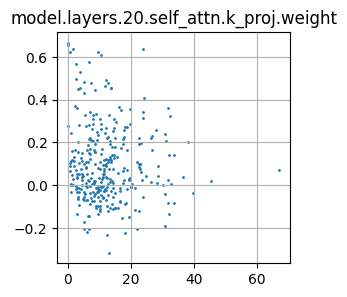

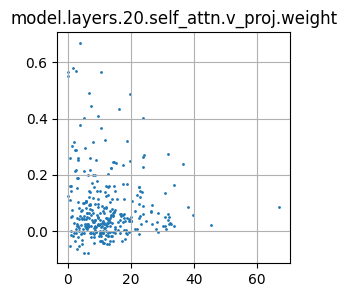

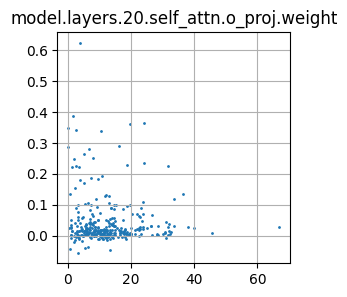

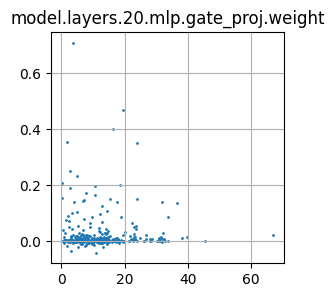

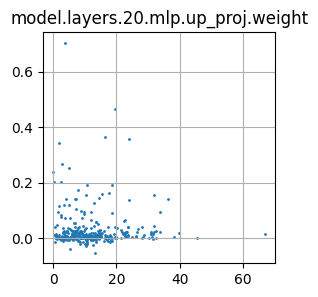

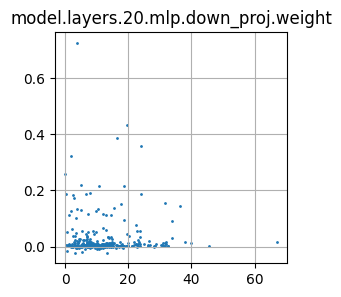

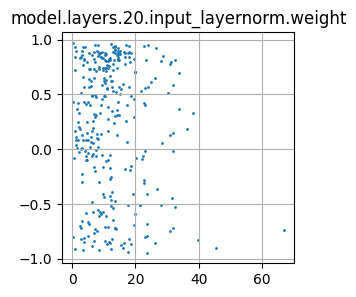

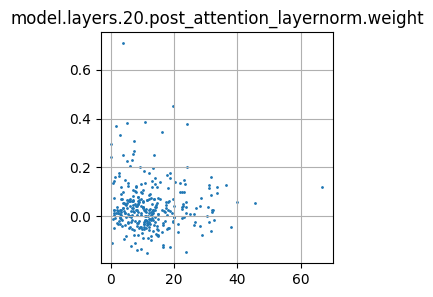

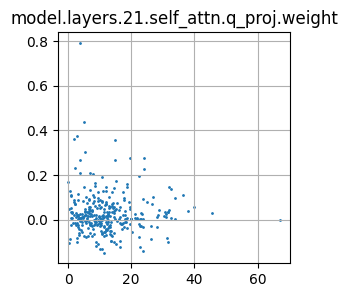

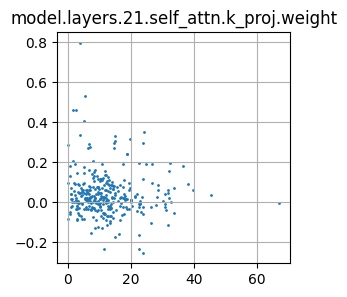

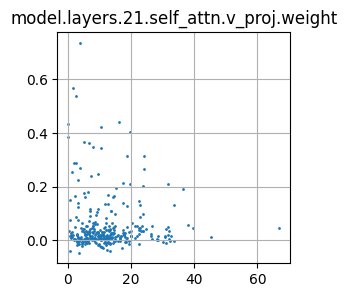

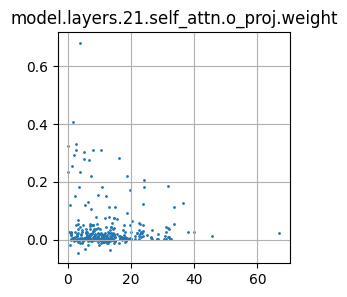

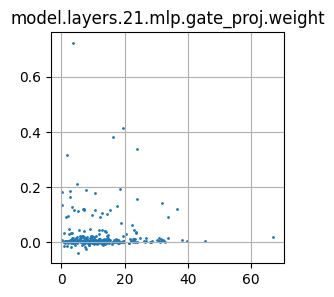

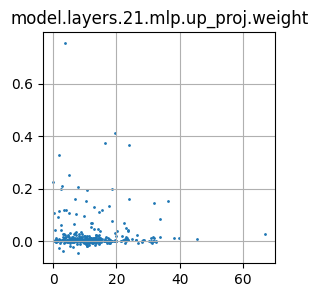

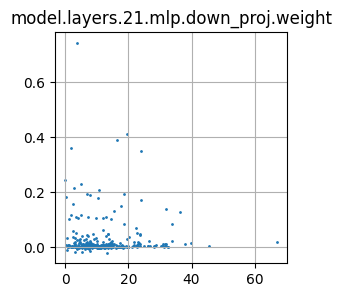

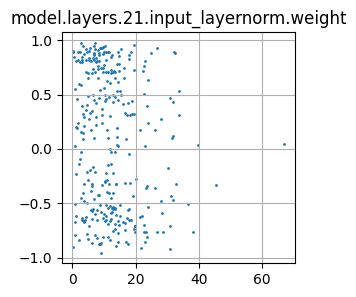

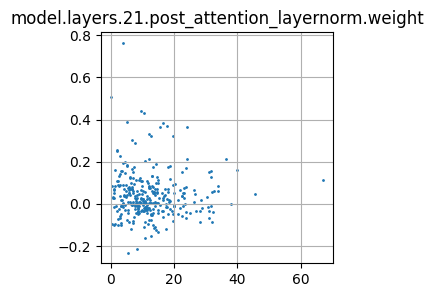

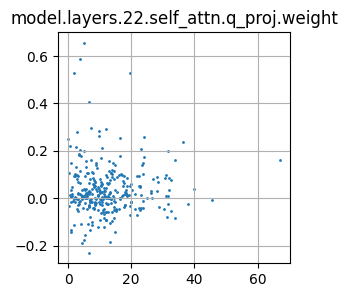

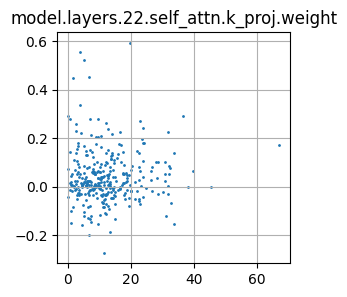

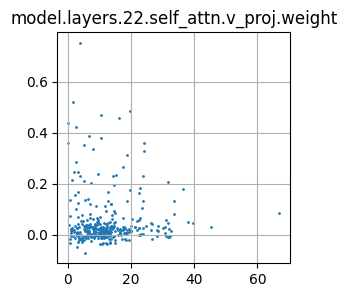

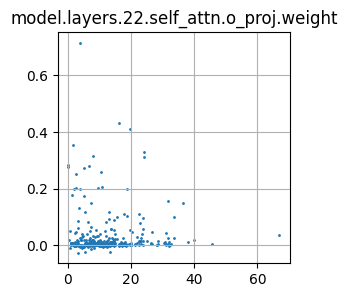

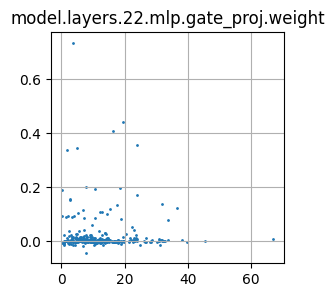

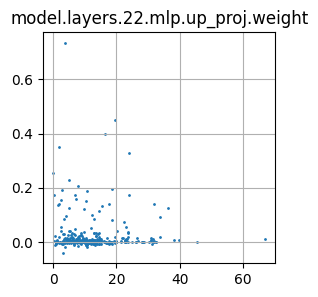

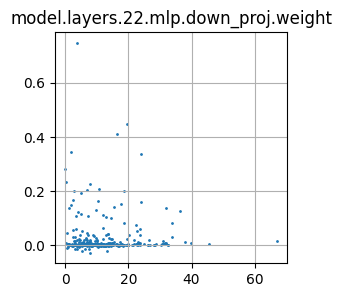

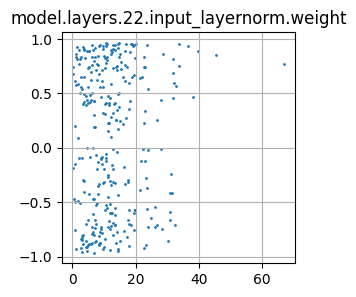

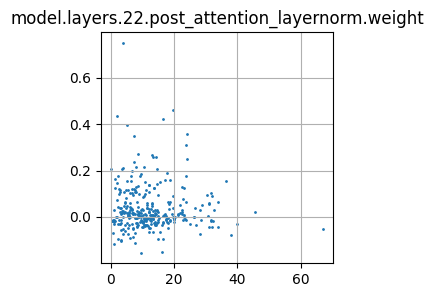

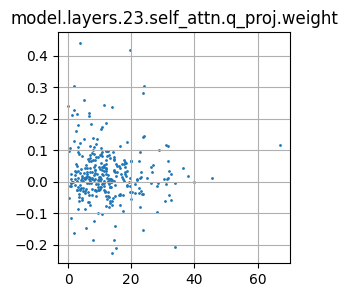

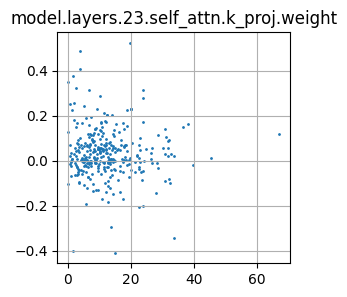

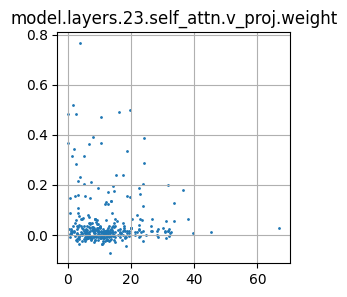

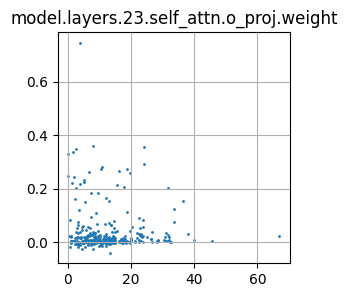

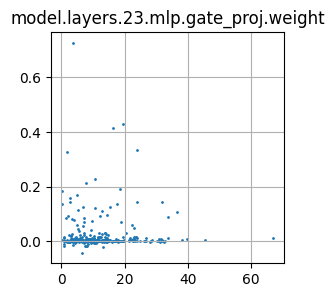

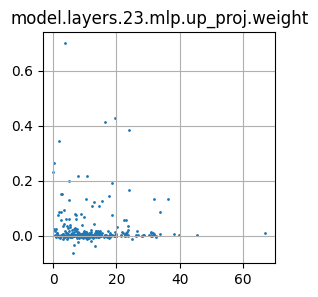

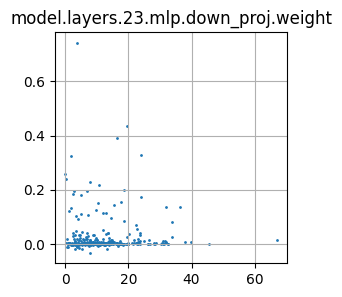

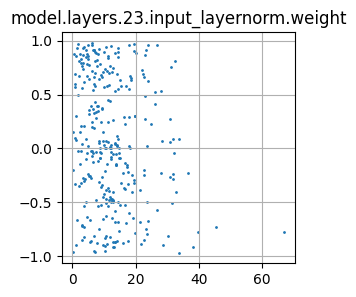

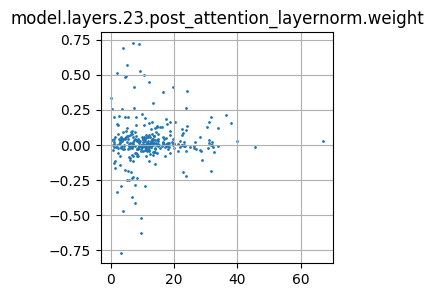

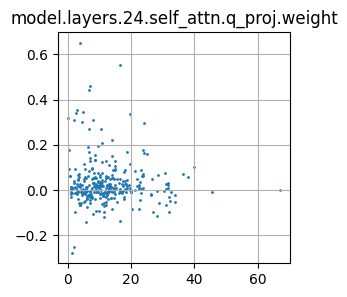

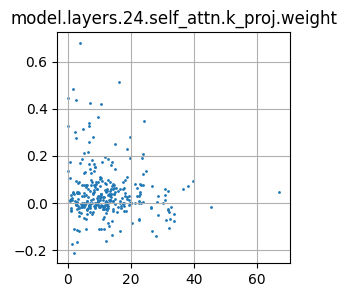

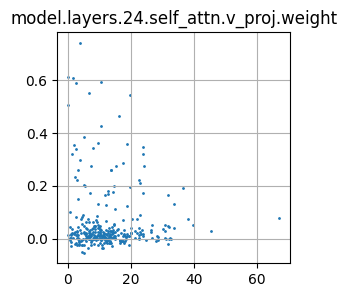

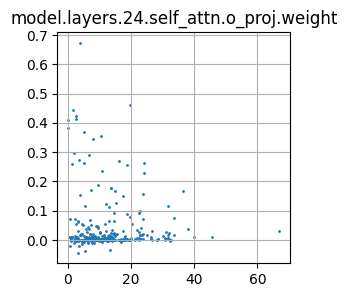

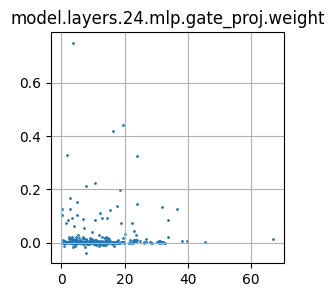

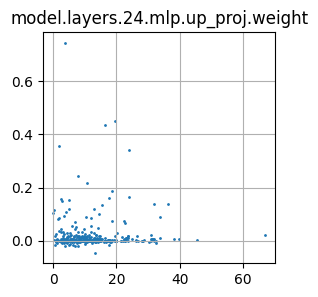

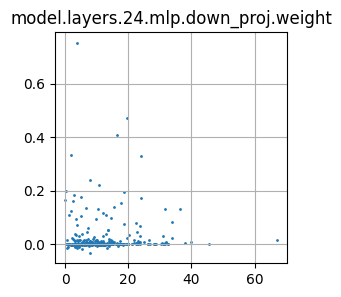

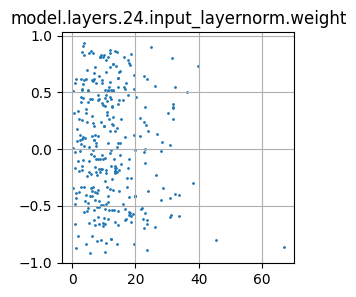

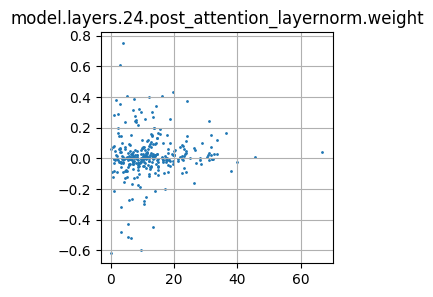

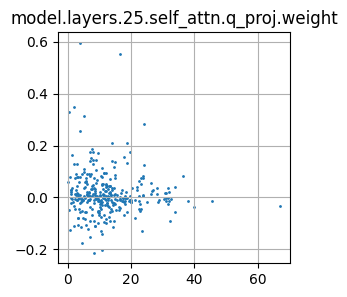

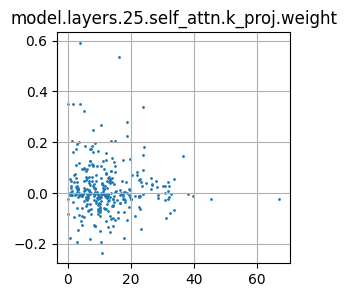

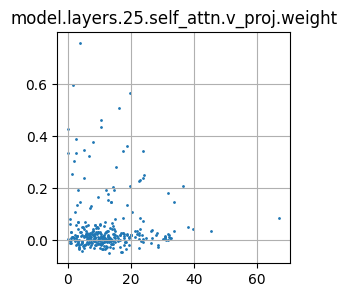

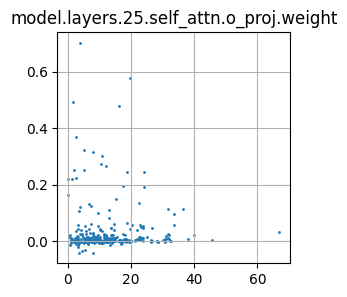

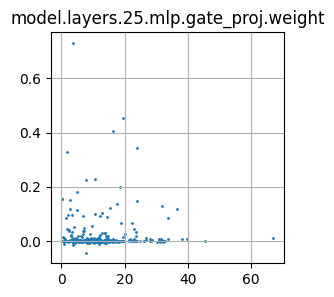

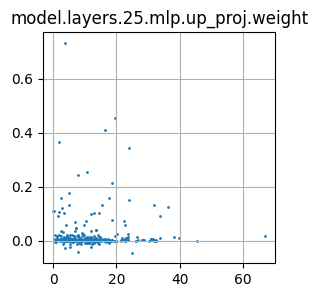

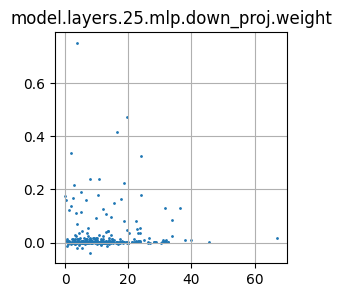

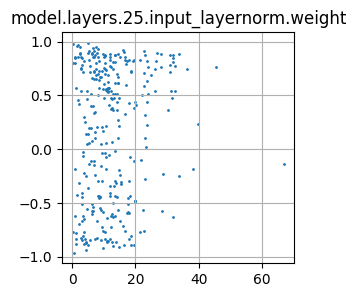

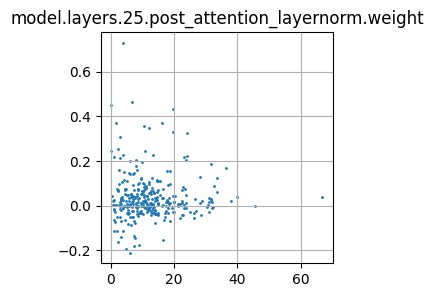

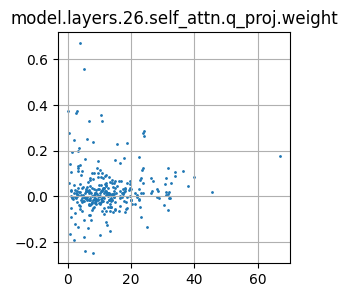

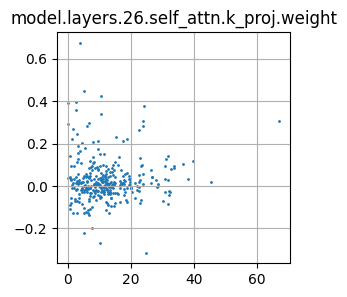

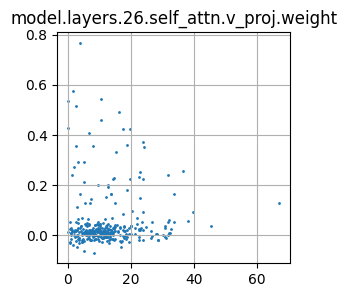

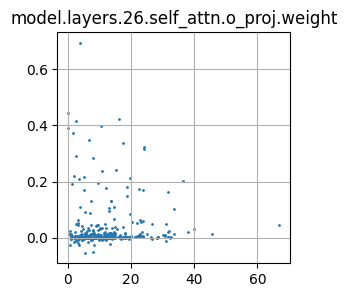

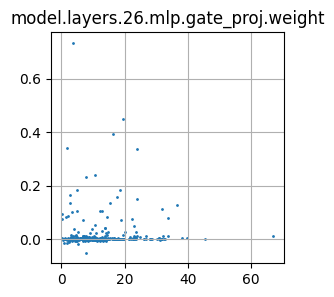

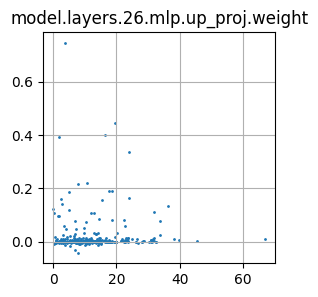

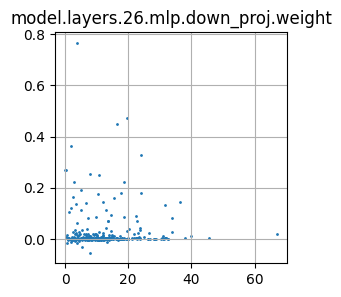

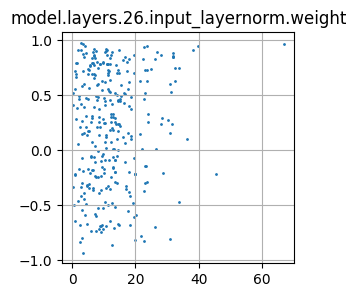

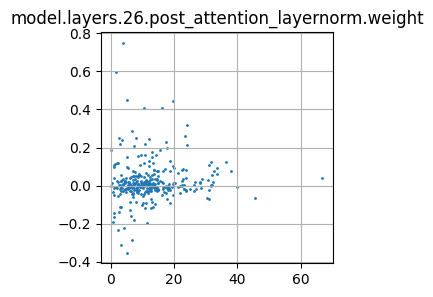

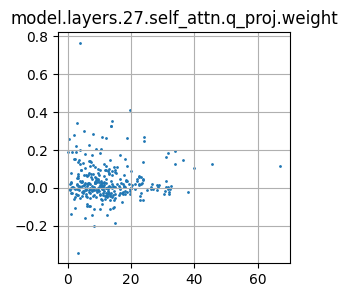

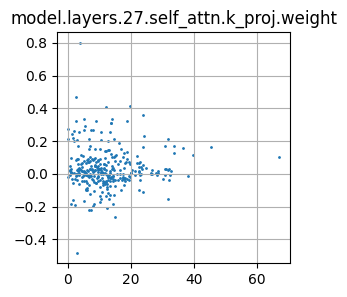

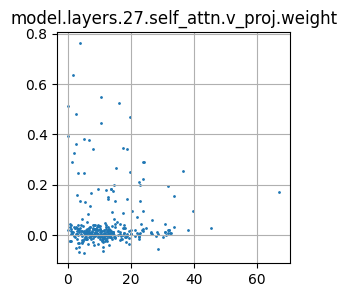

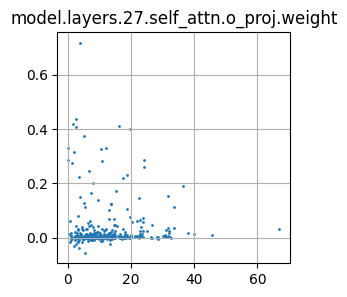

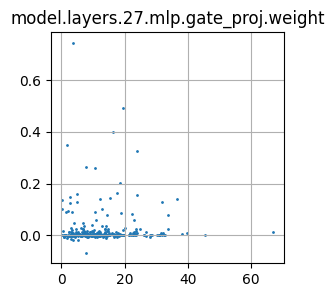

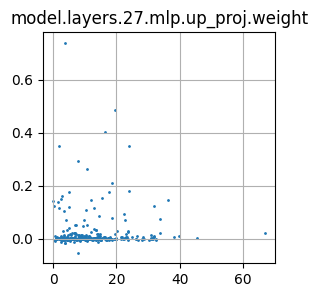

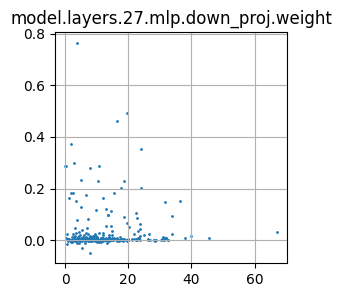

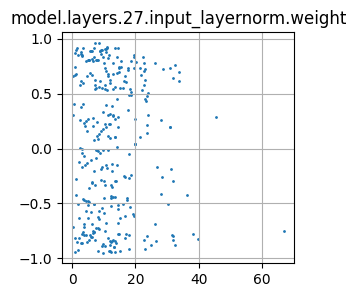

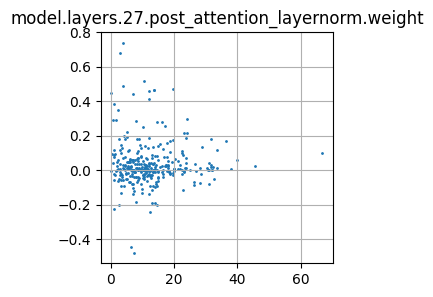

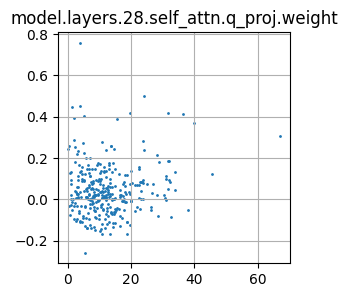

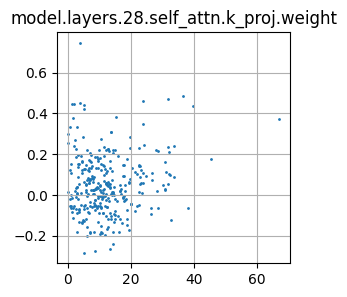

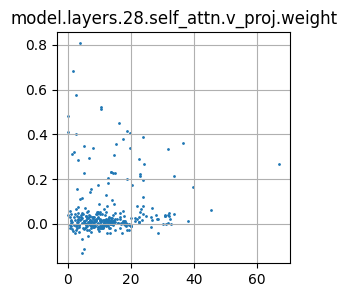

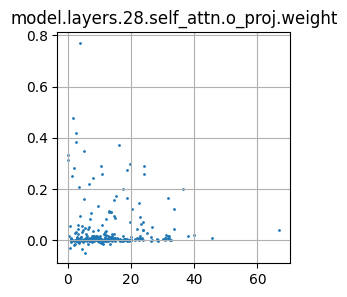

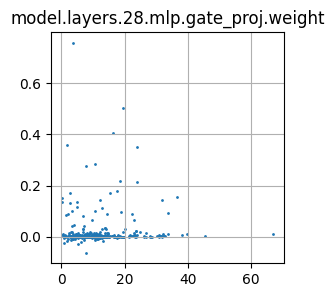

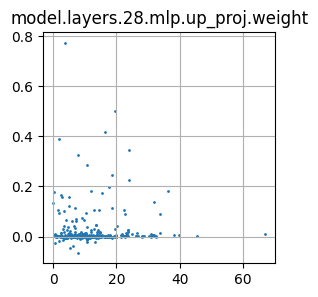

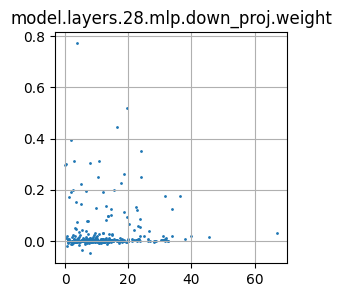

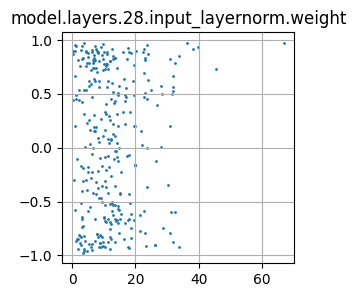

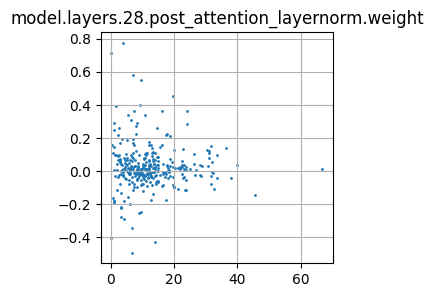

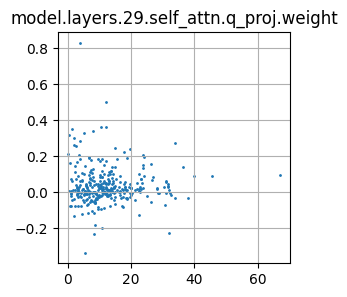

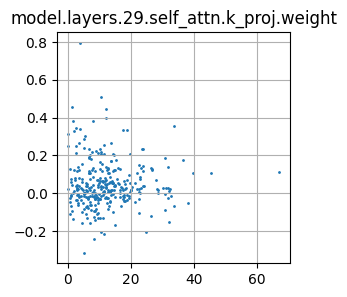

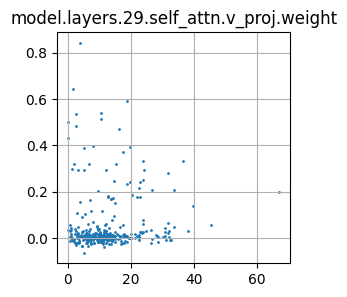

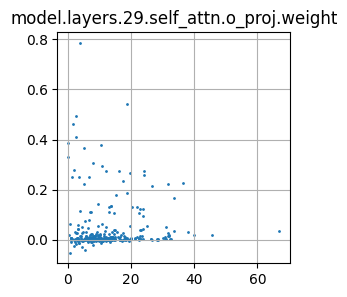

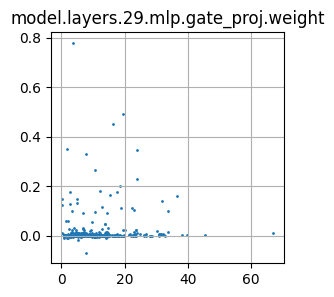

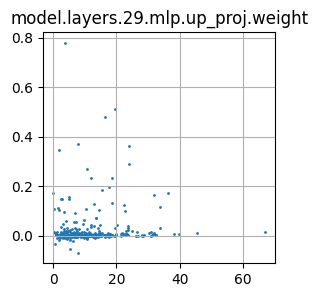

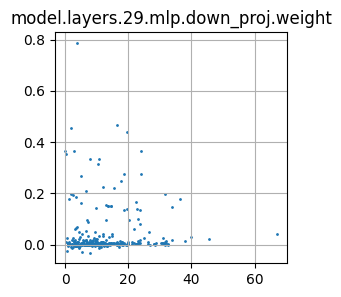

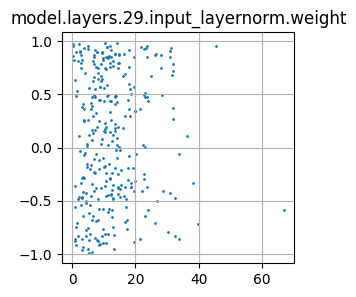

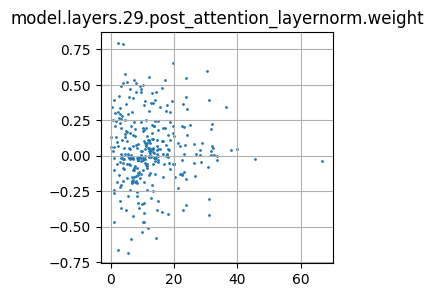

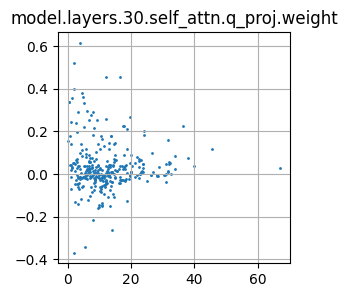

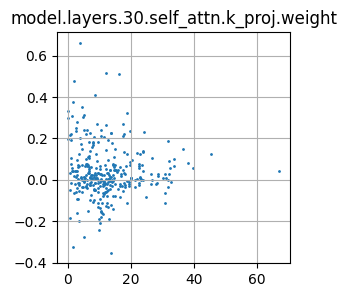

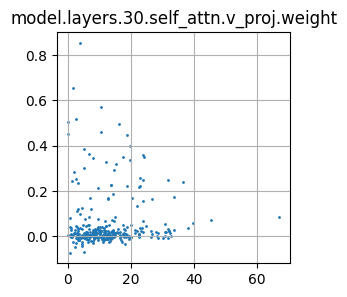

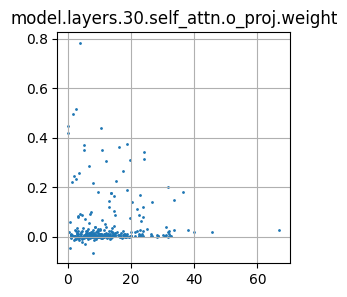

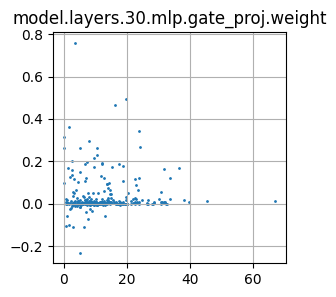

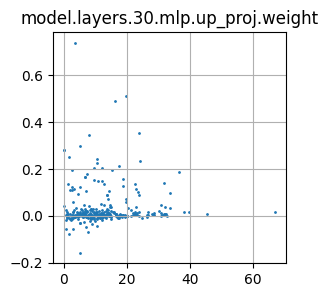

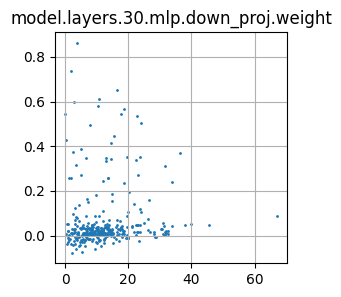

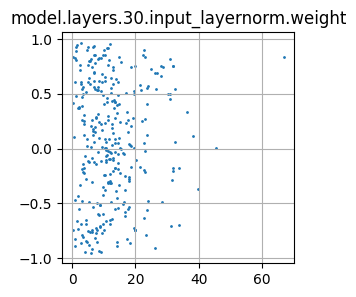

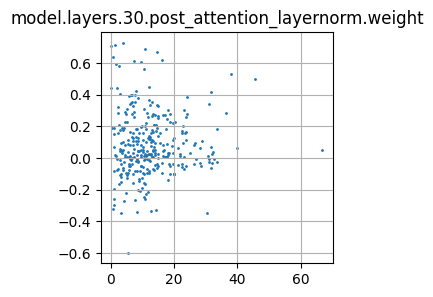

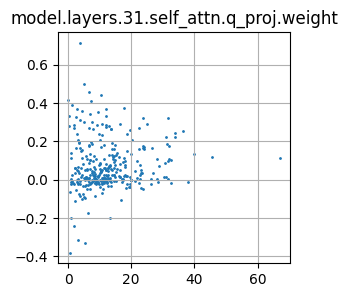

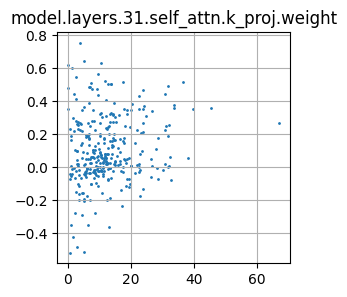

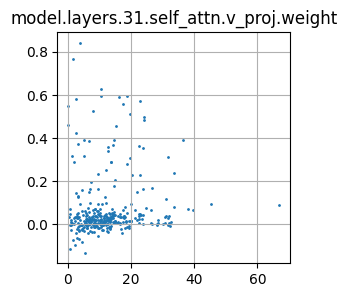

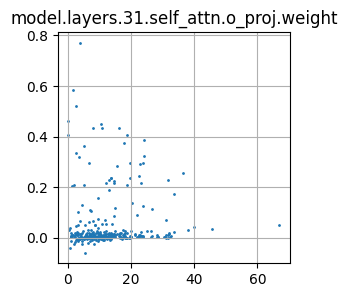

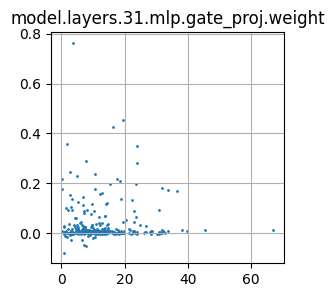

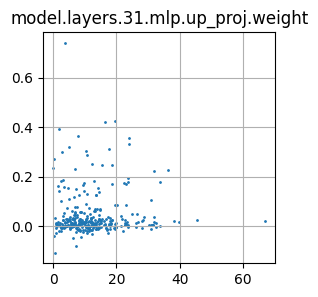

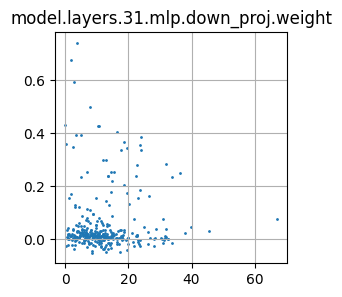

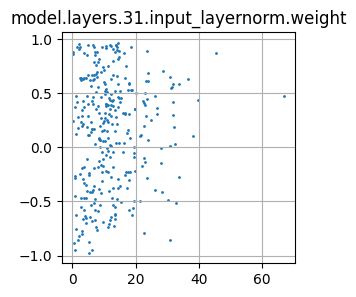

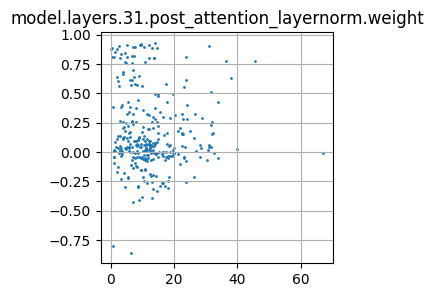

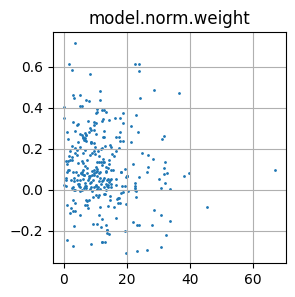

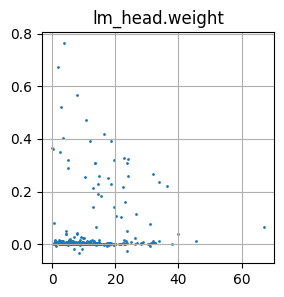

In [5]:
import matplotlib.pyplot as plt
names = [i for i in inner_product_results[0]['inner_product']]
for name in names:
    a = [one['inner_product'][name] for one in inner_product_results]
    y = [min(one['NLL']) for one in inner_product_results]
    plt.figure(figsize=(3,3))
    plt.scatter(y,a,s=1)
    plt.grid(True)
    plt.title(f"{name}")
    # plt.show()
    plt.savefig(f"/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/plots/{name}.png")